In [1]:
import random
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn
import skopt

import dill
import json
from tqdm.auto import tqdm

import gc
import warnings
warnings.filterwarnings("ignore")

from utils.vis_db import discrete_cmap, patch_3d_axis, get_fixed_lim, style_3d_ax
patch_3d_axis()

In [2]:
c_tags = [    'C_10',      'C_07',      'C_05',      'C_02']
c_txts = ['10 mg/mL', '7.5 mg/mL', '5.0 mg/mL', '2.5 mg/mL']
c_nums = [        10,         7.5,           5,         2.5]
c_txts_lut = {k: v for k, v in zip(c_tags, c_txts)}
c_nums_lut = {k: v for k, v in zip(c_tags, c_nums)}
    
feas_df = pd.read_csv('data/db_train.csv')

from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

search_space = {
    'C':     (1e-1, 1e+2, 'log-uniform'),
    'gamma': (1e-5, 1e+1, 'log-uniform')
}


feas_models = {}
for col in c_tags:
    sub_df = feas_df[(feas_df[col] == 1)]
    opt = BayesSearchCV(sklearn.svm.SVR(), search_space, n_iter=16, random_state=0,
                        cv=RepeatedKFold(n_splits=5, random_state=0))

    opt.fit(sub_df[['CNF', 'MXN']], sub_df['score_ternary'])
    feas_models[col] = opt


In [3]:
cbar_labels = ['C', 'B', 'A']
vmin, vmax = 0, 1
cbar_ticks = [1/6, 3/6, 5/6]

cmap_d = discrete_cmap(3, over='r', under='b', bad='w', values=[0.1, 0.3, 0.8])
cmap_2 = discrete_cmap(2, values=[0.1, 0.8])
cmap_c = discrete_cmap(65536)

In [5]:
import matplotlib.tri as tri

n_points = 251
y_col = 'score_ternary'

feas_tri_cache = {}

for col in c_tags:
    model = feas_models[col]
    
    xx = np.linspace(0, 1, num=n_points)
    X, Y = np.meshgrid(xx, xx)
    Zb = model.predict(np.array([X.flatten(), Y.flatten()]).T).reshape(X.shape).clip(vmin, vmax)
    Zc = model.predict(np.array([X.flatten(), Y.flatten()]).T).reshape(X.shape).clip(vmin, vmax)
    
    tx = X.flatten()
    ty = Y.flatten()
    tzb = Zb.flatten()
    tzc = Zc.flatten()

    mask = (tx + ty) <= 1.0
    tx = tx[mask]
    ty = ty[mask]
    tzb = tzb[mask]
    tzc = tzc[mask]
    
    triang = tri.Triangulation(tx, ty)
    feas_tri_cache[col] = tx, ty, tzb, tzc, triang.triangles
feas_tri_cache

{'C_10': (array([0.   , 0.004, 0.008, ..., 0.   , 0.004, 0.   ]),
  array([0.   , 0.   , 0.   , ..., 0.996, 0.996, 1.   ]),
  array([0., 0., 0., ..., 1., 1., 1.]),
  array([0., 0., 0., ..., 1., 1., 1.]),
  array([[19996, 19997, 20149],
         [28850, 28924, 28849],
         [20300, 20450, 20299],
         ...,
         [ 4050,  4049,  3813],
         [ 3813,  4048,  3812],
         [ 3813,  4049,  4048]], dtype=int32)),
 'C_07': (array([0.   , 0.004, 0.008, ..., 0.   , 0.004, 0.   ]),
  array([0.   , 0.   , 0.   , ..., 0.996, 0.996, 1.   ]),
  array([0.02154421, 0.03506372, 0.04893136, ..., 1.        , 1.        ,
         1.        ]),
  array([0.02154421, 0.03506372, 0.04893136, ..., 1.        , 1.        ,
         1.        ]),
  array([[19996, 19997, 20149],
         [28850, 28924, 28849],
         [20300, 20450, 20299],
         ...,
         [ 4050,  4049,  3813],
         [ 3813,  4048,  3812],
         [ 3813,  4049,  4048]], dtype=int32)),
 'C_05': (array([0.   , 0.004, 0.0

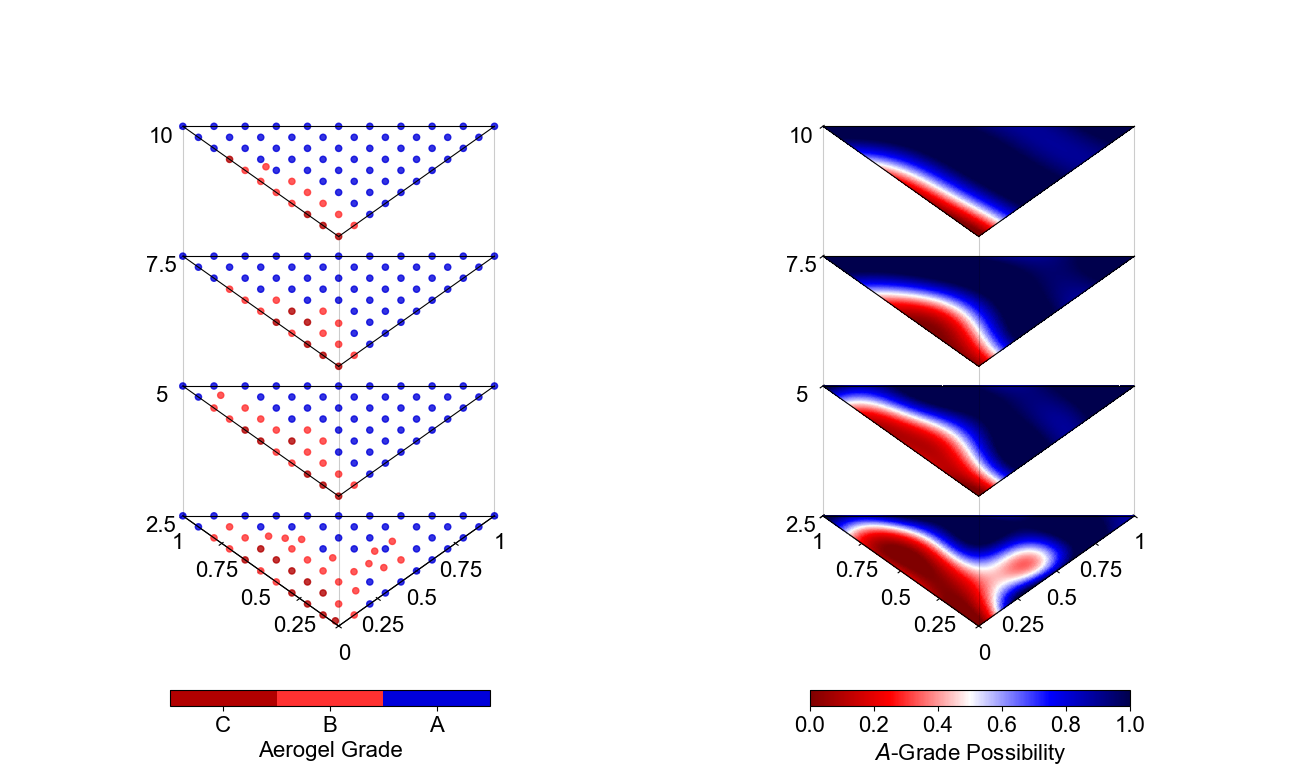

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 2 * fig_size / z_aspect, fig_size), 
                               subplot_kw=dict(projection='3d'), 
                               gridspec_kw=dict(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0))

for col, z_loc in zip(c_tags, reversed(z_locs)):
    sub_df = feas_df[feas_df[col] == 1]
    surf = ax1.scatter(sub_df['CNF'], sub_df['MXN'], np.ones_like(sub_df['CNF']) * z_loc, 
                       c=sub_df['score_ternary'], cmap=cmap_d, vmin=vmin, vmax=vmax, alpha=0.8, zorder=-1)

for col, z_loc in zip(c_tags, reversed(z_locs)):
    tx, ty, tzb, tzc, triangles = feas_tri_cache[col]
    patch_colors = cmap_c(tzc[triangles]).mean(axis=1)
    surf = ax2.plot_trisurf(tx, ty, np.ones_like(tx) * z_loc, 
                            triangles=triangles, linewidth=0, antialiased=False, shade=True)
    surf.set_fc(patch_colors)


cbars = []
for ax, label, cmap, ticks, labels in [
    (ax1, 'Aerogel Grade', cmap_d, cbar_ticks, cbar_labels),
    (ax2, '$A$-Grade Possibility', cmap_c, [0, 0.2, 0.4, 0.6, 0.8, 1.0], [f'{v:.1f}' for v in [0, 0.2, 0.4, 0.6, 0.8, 1.0]]),
]:

    style_3d_ax(ax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), 
                        ax=[ax, ], shrink=0.5, pad=0.05, ticks=ticks, label=label, location='bottom')
    cbar.set_ticklabels(labels)
    cbar.set_alpha(1) 
    cbars.append(cbar)

fig